In [57]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
from scipy.stats import mannwhitneyu, ttest_ind
from os.path import join
from glob import glob
import warnings
import logging

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings("ignore")

In [58]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
def load_sample_info(file_path):
    df = pd.read_csv(file_path, sep='\t')[[
        'sample_ID', 'rookery-region', 'Year', 'group-Lkadj',
        'Management units - based on DNA', 'Post_dupe_depth_2_all_LKGATK_USE',
        'Exclude-all_GL_ROH_analyses', 'Sequencing_source-type', 'Stage_Class'
    ]]
    return df.rename(columns={
        'sample_ID': 'sample',
        'rookery-region': 'rookery',
        'Year': 'year',
        'group-Lkadj': 'group',
        'Management units - based on DNA': 'MU',
        'Post_dupe_depth_2_all_LKGATK_USE': 'depth',
        'Exclude-all_GL_ROH_analyses': 'exclude',
        'Sequencing_source-type': 'batch',
        'Stage_Class': 'stage'
    })

In [4]:
def apply_color_palette(group_col):
    palettes = {
        'rookery': rookery_palette_dict,
        'MU': mu_palette_dict,
        'batch': batch_palette_dict,
        'group': population_palette_dict
    }
    return palettes.get(group_col, None)

# 0. Load location and groupings information

In [7]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'dc_222_samples_info.tsv'
file_data = glob(join(dir_path, file_name))[0]
INFO = load_sample_info(file_data)

## 0.1. Define colors

In [8]:
rookery_palette_dict = {
    'Mexico': '#1f77b4',
    'Atl Costa Rica': '#005a32',
    'Indonesia': '#d62728',
    'Pacific Costa Rica': '#7570b3',
    'Papua New Guinea': '#dd3497',
    'Solomon Islands': '#fde0dd',
    'Malaysia': '#2ca02c',
    'South Africa': '#17becf',
    'Ghana': '#ff7f0e',
    'Gabon': '#fdd0a2',
    'French Guiana-Suriname': '#8c564b',
    'Virgin Islands': '#d6eaf8',
    'Florida': '#d9f0a3',
    'na': '#000000',
    'unknown': '#7f7f7f'}

mu_palette_dict = {
    'Eastern Pacific': '#1f77b4',
    'Western Pacific': '#d62728',
    'Northwest Caribbean': '#005a32',
    'Northeast Caribbean': '#6a51a3',
    'Northern Caribbean': '#d9f0a3',
    'South Africa': '#17becf',
    'SE Atlantic/West Africa': '#ff7f0e',
    'South-east Caribbean': '#8c564b',
    'Indo-Western Pacific': '#2ca02c',
    'na': '#000000',
    'unknown': '#7f7f7f'}

batch_palette_dict = {
    'novo_UMass_Illumina_SR': '#1f77b4',
    'novo42_Illumina_SR': '#ff7f0e',
    'LR-getinfofromJH': '#2ca02c',
    'Duffy_Illumina_SR': '#d62728'}

population_palette_dict = {
    'larger_declining': '#d62728',
    'small_stable':'#1f77b4',
    'small_declining': '#005a32',
    'larger_stable': '#ff7f0e',
    'small_recovering': '#6a51a3'}

In [14]:
pop_order = ['larger_declining', 'small_stable', 'small_declining',
             'larger_stable', 'small_recovering']

## Plot all groups

In [71]:
def plot_impact_stripplots(
    df, impacts, group_vars, hue_palettes, pop_order, y, x='group',
    figsize=(len(impacts)*3, 8), ylim=None, save_path=None):

    fig, axes = plt.subplots(len(group_vars), len(impacts), figsize=figsize)

    for j, group in enumerate(group_vars):
        for i, impact in enumerate(impacts):
            axi = axes[j, i]
            dfi = df[(df['impact'] == impact) & (df['exclude'] == 'include')]
            palette = hue_palettes.get(group, None)

            sns.boxplot(ax=axi, data=dfi, x=x, y=y,
                        showfliers=False, color="#dddddd", order=pop_order)
            
            sns.stripplot(ax=axi, data=dfi, x=x, y=y,
                          hue=group, order=pop_order, alpha=0.8, s=4,
                          linewidth=0.1, palette=palette)

            plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            axi.set_ylabel(f'{y} of {impact} impact SNPs')
            axi.set_xlabel('')
            if ylim:
                axi.set_ylim(ylim)

            if i != len(impacts) - 1:
                axi.get_legend().set_visible(False)
            else:
                sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

    sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
    fig.tight_layout()
    
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    return fig, axes

## Plot main groups

In [84]:
def plot_impact_comparison_two_groups(
    df, impacts, group_vars, pop_pair, hue_palettes, pop_order, y, x='group',
    figsize=(len(impacts)*3, 8), ylim=None, save_path=None):
    
    g1, g2 = pop_pair
    pops = [g1, g2]
    fig, axes = plt.subplots(len(group_vars), len(impacts), figsize=figsize)

    for j, group in enumerate(group_vars):
        for i, impact in enumerate(impacts):
            axi = axes[j, i]
            dfi = df[(df['impact'] == impact) & (df['exclude'] == 'include')]
            dfi = dfi[dfi[x].isin(pops)]

            palette = hue_palettes.get(group, None)

            # Subset for statistical test
            data1 = dfi[dfi[x] == g1][y]
            data2 = dfi[dfi[x] == g2][y]
            stat, pval = mannwhitneyu(data1, data2, alternative='two-sided')

            sns.boxplot(ax=axi, data=dfi, x=x, y=y, showfliers=False,
                        color="#dddddd", order=pop_order)
            
            sns.stripplot(ax=axi, data=dfi, x=x, y=y,
                          hue=group, order=pop_order, alpha=0.8, s=4,
                          linewidth=0.1, palette=palette)

            plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            axi.set_ylabel(f'{y} of {impact} impact SNPs')
            axi.set_xlabel('')
            y_max = dfi[y].max() * 1.05
            axi.set_ylim(None, y_max)

            # Add bar and p-value
            axi.plot([0, 0, 1, 1], [y_max * 0.99, y_max, y_max, y_max * 0.99], lw=1, color='black')
            axi.text(0.5, y_max * 1.01, f"p = {pval:.1e}", ha='center', va='bottom', fontsize=9)

            if i != len(impacts) - 1:
                axi.get_legend().set_visible(False)
            else:
                sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

    sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    return fig, axes

# 1. Genetic load: snpEff

In [65]:
## Read summary file with total number of variants by impact
dc = '222'
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = f'snpEff_{dc}/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location info to each sample
df = df[df['state'] != 'hom_ref']
df_all = pd.merge(df, INFO, on='sample')

## Exclude samples that are not for genetic load analysis
df_all['exclude'] = df_all['exclude'].fillna('include')

## 1.1. Plot total number of variants by impact
#### NB: each impact can additionally be MODIFIER (snpEff can annotate a SNP as both HIGH and MODIFIER) => MODIFIER here are variants that are annotated ONLY as modifier and no other class! 

In [66]:
grouped_df = df_all.groupby(['sample', 'impact', 'MU', 'rookery',
                             'year', 'group', 'exclude', 'batch']).sum().reset_index()

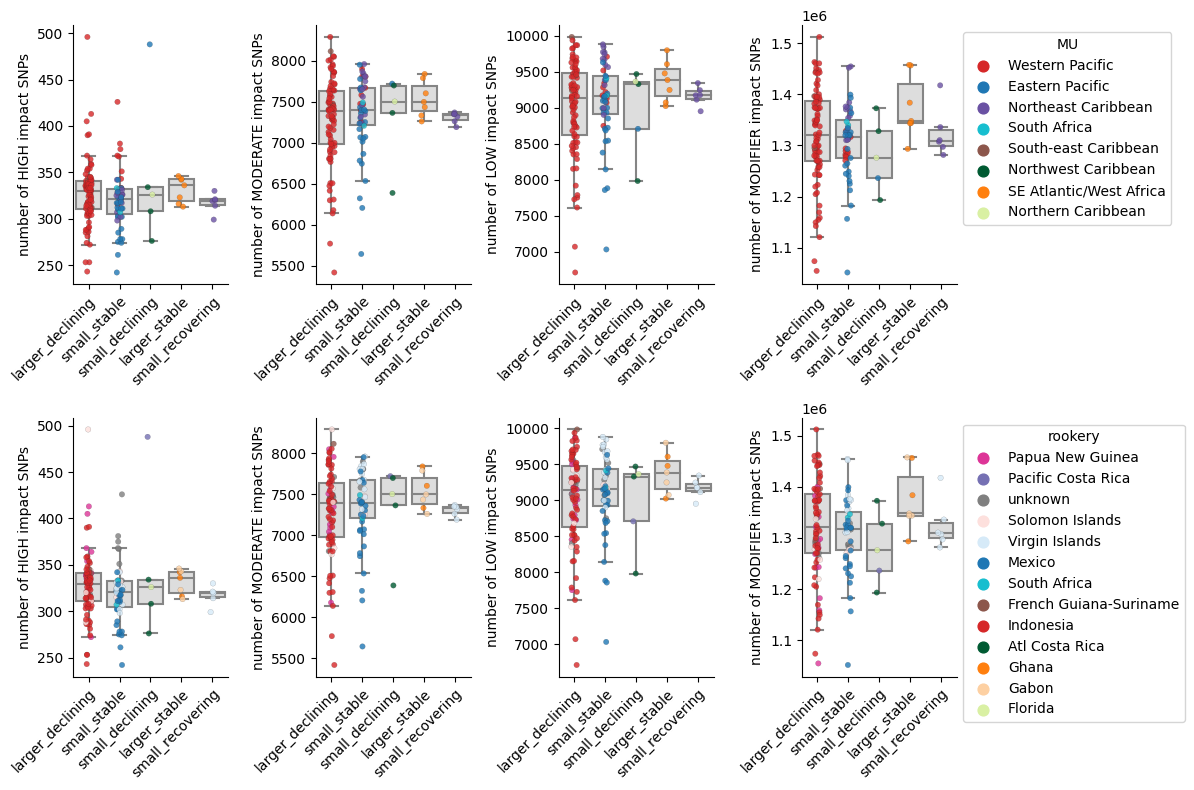

In [72]:
plot_impact_stripplots(
    df=grouped_df,
    y='number',
    impacts=['HIGH', 'MODERATE', 'LOW', 'MODIFIER'],
    group_vars=['MU', 'rookery'],
    hue_palettes={'MU': mu_palette_dict, 'rookery': rookery_palette_dict},
    pop_order=pop_order,
    save_path=f'{y}_snps_by_impact.all.pdf');

## Total number: main groups only

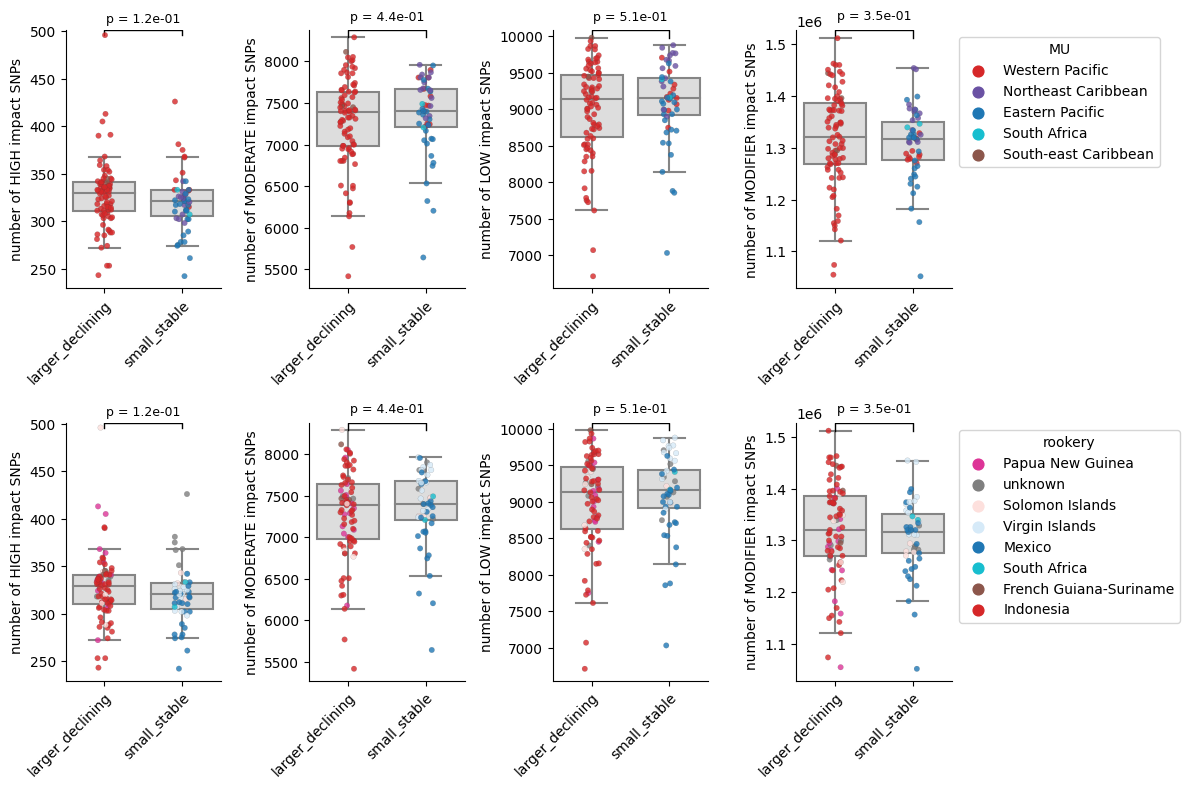

In [74]:
plot_impact_comparison_two_groups(
    df=grouped_df,
    y='number',
    impacts=['HIGH', 'MODERATE', 'LOW', 'MODIFIER'],
    group_vars=['MU', 'rookery'],
    pop_pair=('larger_declining', 'small_stable'),
    hue_palettes={'MU': mu_palette_dict, 'rookery': rookery_palette_dict},
    pop_order=pop_order,
    save_path=f'{y}snps_by_impact.L_S.pdf');

## 1.2. Plot fraction of SNPs by impact

In [75]:
G = grouped_df.groupby(['sample']).sum().reset_index()[['sample', 'number']]
G.rename({'number': 'total'}, axis='columns', inplace=True)

merged_df = pd.merge(grouped_df, G, on='sample')
merged_df['fraction'] = merged_df['number'] / merged_df['total'] * 100

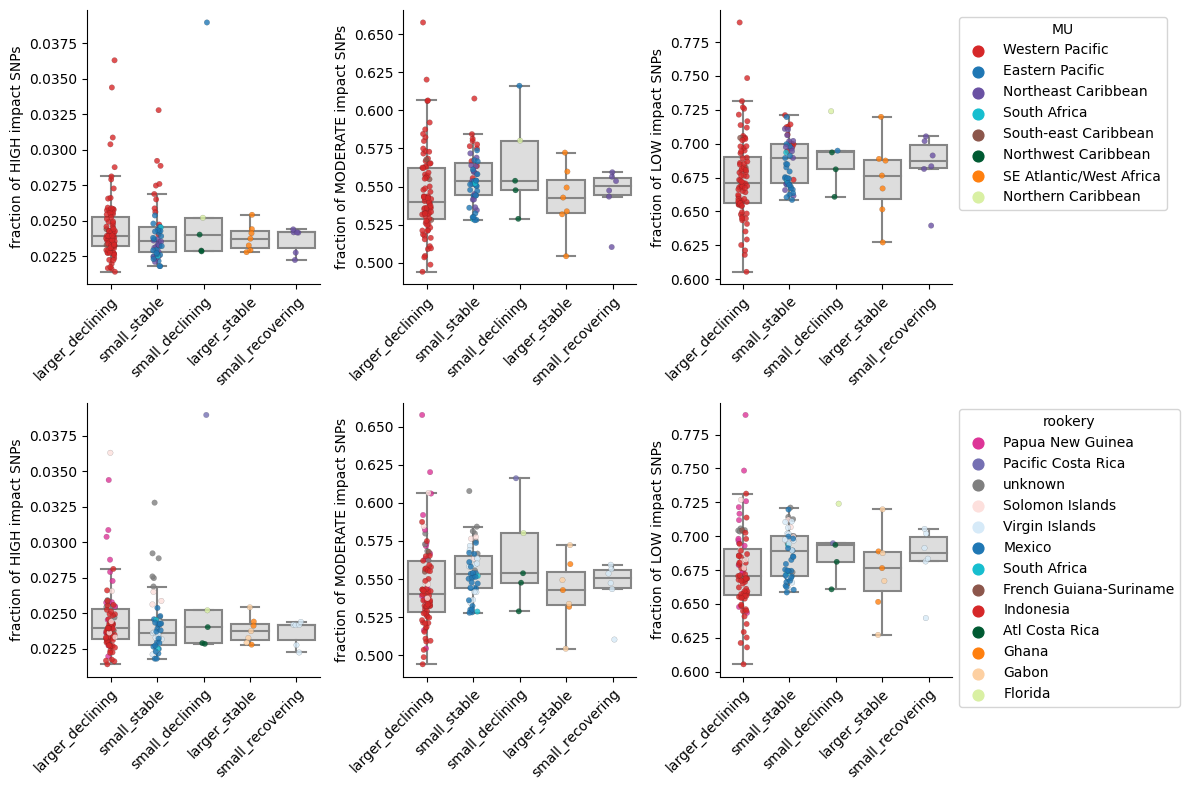

In [76]:
plot_impact_stripplots(
    df=merged_df,
    y = 'fraction',
    impacts=['HIGH', 'MODERATE', 'LOW'],
    group_vars=['MU', 'rookery'],
    hue_palettes={'MU': mu_palette_dict, 'rookery': rookery_palette_dict},
    pop_order=pop_order,
    save_path=f'{y}_snps_by_impact.all.pdf');

## Fraction: main groups only

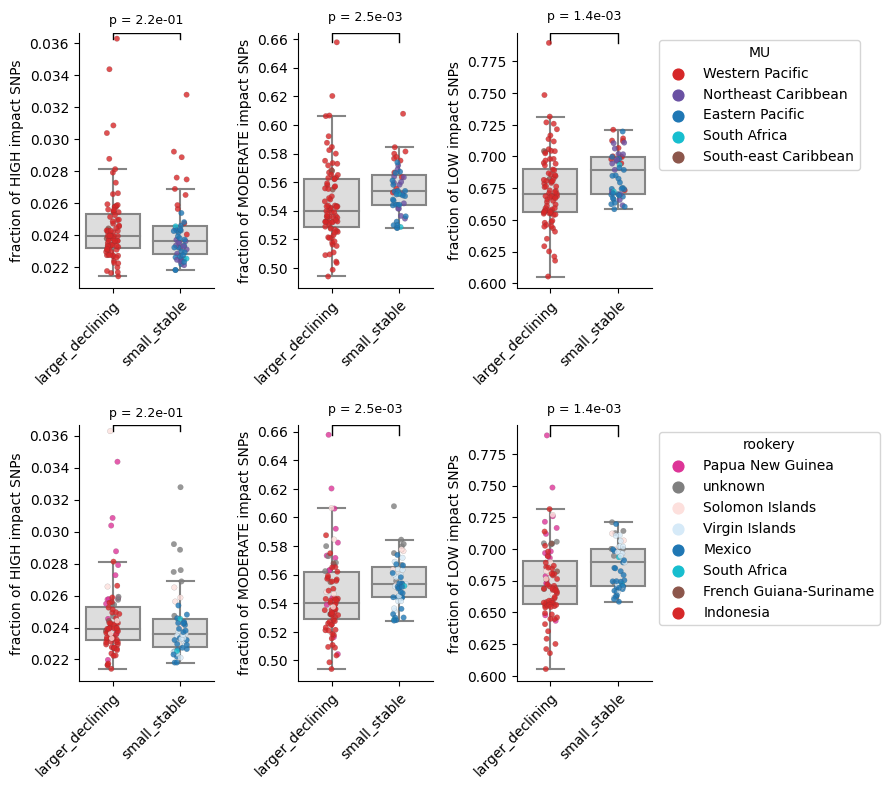

In [78]:
y = 'fraction'
impacts = ['HIGH', 'MODERATE', 'LOW']

plot_impact_comparison_two_groups(
    df=merged_df,
    y=y,
    impacts=impacts,
    group_vars=['MU', 'rookery'],
    pop_pair=('larger_declining', 'small_stable'),
    hue_palettes={'MU': mu_palette_dict, 'rookery': rookery_palette_dict},
    pop_order=pop_order,
    figsize=(len(impacts)*3, 8),
    save_path=f'{y}_snps_by_impact.L_S.pdf');

## 1.3. Plot homozygotes by impact
#### NB: all homozygotes are alt alleles! never 0/0, only 1/1, 1|1, and rarely 2/2, 3/3, ... etc for indels
#### Since the majority of HIGH impact variants are LOF (>70%), classes HIGH and LOF are almost equivalent. Leave only LOF

In [80]:
grouped_df = df_all.groupby(['sample', 'impact', 'MU', 'rookery', 'year', 
                             'state', 'group', 'exclude', 'batch']).sum().reset_index()
# Exclude 'MODIFIER' snps
grouped_df = grouped_df[grouped_df['impact'] != 'MODIFIER']

# Include only homozygotes
grouped_df = grouped_df[grouped_df['state'] == 'hom']

In [81]:
G = grouped_df.groupby(['sample']).sum().reset_index()[['sample', 'number']]
G.rename({'number': 'total'}, axis='columns', inplace=True)

merged_df = pd.merge(grouped_df, G, on='sample')
merged_df['fraction'] = merged_df['number'] / merged_df['total'] * 100

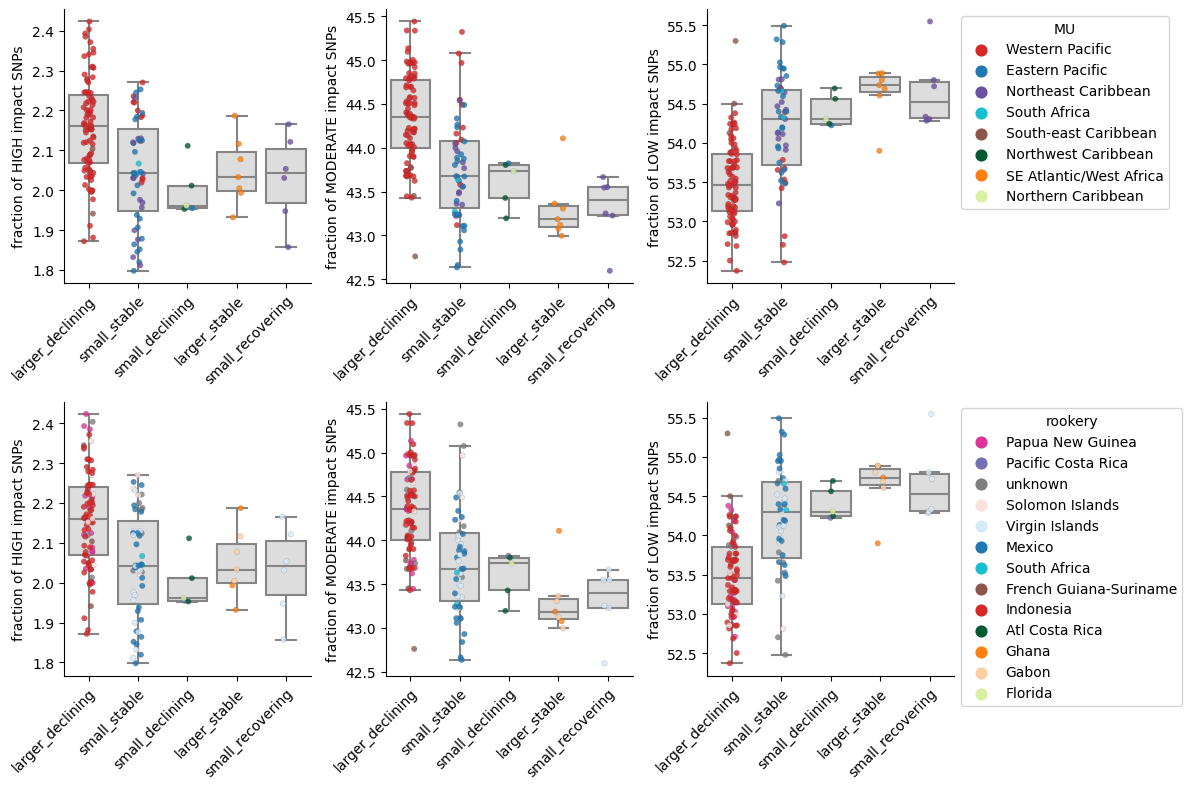

In [82]:
plot_impact_stripplots(
    df=merged_df,
    y = 'fraction',
    impacts=['HIGH', 'MODERATE', 'LOW'],
    group_vars=['MU', 'rookery'],
    hue_palettes={'MU': mu_palette_dict, 'rookery': rookery_palette_dict},
    pop_order=pop_order,
    save_path=f'{y}_homs_by_impact.all.pdf');

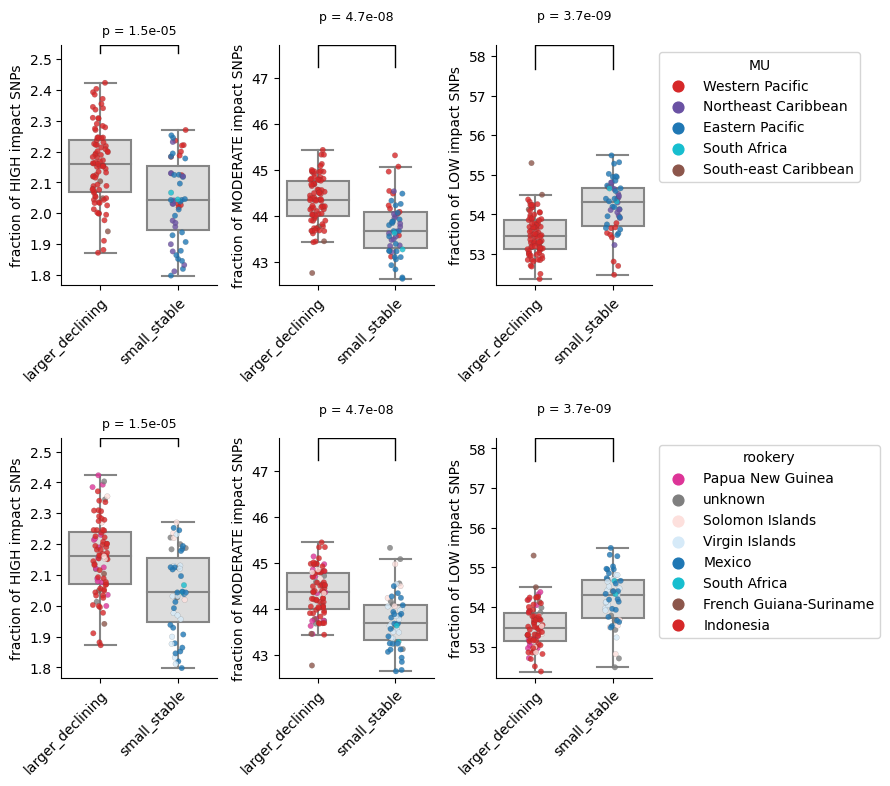

In [85]:
plot_impact_comparison_two_groups(
    df=merged_df,
    y='fraction',
    impacts=['HIGH', 'MODERATE', 'LOW'],
    group_vars=['MU', 'rookery'],
    pop_pair=('larger_declining', 'small_stable'),
    hue_palettes={'MU': mu_palette_dict, 'rookery': rookery_palette_dict},
    pop_order=pop_order,
    figsize=(len(impacts)*3, 8),
    save_path=f'{y}_homs_by_impact.L_S.pdf');

# 2. Genetic load: ANNOVAR

In [86]:
dc = '222'
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = f'ANNOVAR_{dc}/all_samples.snp_indel_hom_het_by_impact.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df = df[df['state'] != 'hom_ref']

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')
df_all['exclude'] = df_all['exclude'].fillna('include')

In [87]:
grouped_df = df_all.groupby(['sample', 'impact', 'MU', 'rookery',
                             'year', 'group', 'exclude', 'batch']).sum().reset_index()

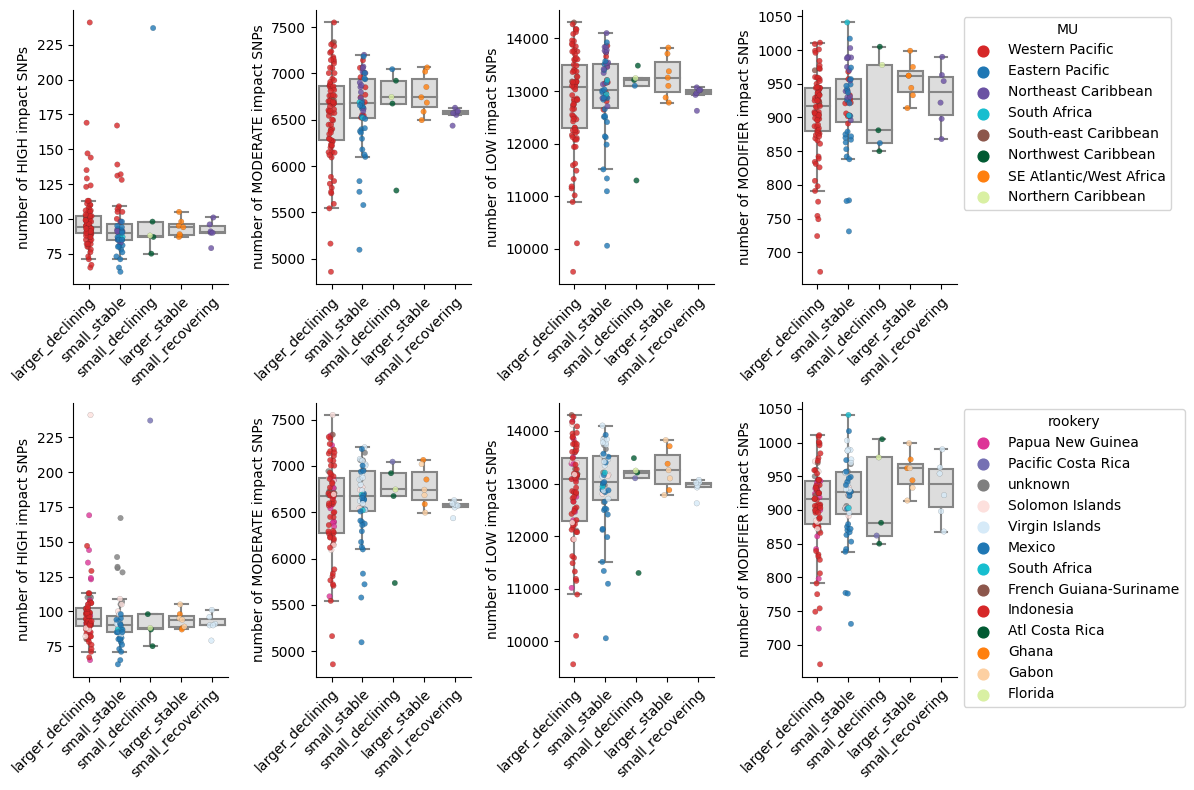

In [91]:
impacts = ['HIGH', 'MODERATE', 'LOW', 'MODIFIER']
plot_impact_stripplots(
    df=grouped_df,
    y='number',
    impacts=impacts,
    group_vars=['MU', 'rookery'],
    hue_palettes={'MU': mu_palette_dict, 'rookery': rookery_palette_dict},
    pop_order=pop_order,
    figsize=(len(impacts)*3, 8),
    save_path=f'{y}_snps_by_impact.all.ANNOVAR.pdf');